# Task 4 - Sleep Staging

In this task we will perform sequence classification. We will categorize temporally coherent and uniformly distributed short sections of a long time-series. In particular, for each 4 seconds of a lengthy EEG/EMG measurement of brain activity recorded during sleep, we will assign one of the 3 classes corresponding to the sleep stage present within the evaluated epoch.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, GRU
from keras.losses import CategoricalCrossentropy
from keras import backend as K
from sklearn.svm import SVC

In [3]:
train_eeg1 = pd.read_csv("train_eeg1.csv", index_col='Id')
train_eeg2 = pd.read_csv("train_eeg2.csv", index_col='Id')
train_emg = pd.read_csv("train_emg.csv", index_col='Id')
y_train = pd.read_csv("train_labels.csv", index_col='Id')

In [4]:
train_eeg1.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,x512
count,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,...,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000
mean,-0.000032,-0.000030,-0.000030,-0.000030,-0.000029,-0.000029,-0.000031,-0.000031,-0.000032,-0.000033,...,-0.000034,-0.000034,-0.000034,-0.000034,-0.000034,-0.000033,-0.000032,-0.000033,-0.000033,-0.000032
std,0.000497,0.000496,0.000496,0.000496,0.000497,0.000498,0.000497,0.000498,0.000498,0.000497,...,0.000499,0.000499,0.000499,0.000499,0.000499,0.000498,0.000498,0.000497,0.000498,0.000498
min,-0.002500,-0.002700,-0.002400,-0.002400,-0.002500,-0.002400,-0.002300,-0.002400,-0.002800,-0.002600,...,-0.002900,-0.002800,-0.002800,-0.002600,-0.002600,-0.002700,-0.002800,-0.002700,-0.003200,-0.002900
25%,-0.000350,-0.000350,-0.000350,-0.000350,-0.000350,-0.000350,-0.000350,-0.000350,-0.000350,-0.000350,...,-0.000360,-0.000350,-0.000360,-0.000360,-0.000360,-0.000350,-0.000360,-0.000350,-0.000360,-0.000350
50%,-0.000034,-0.000035,-0.000036,-0.000036,-0.000031,-0.000033,-0.000039,-0.000039,-0.000038,-0.000038,...,-0.000040,-0.000040,-0.000038,-0.000039,-0.000041,-0.000038,-0.000036,-0.000039,-0.000038,-0.000038
75%,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,...,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280
max,0.003300,0.003300,0.002700,0.003100,0.003100,0.002900,0.002900,0.002500,0.002700,0.003000,...,0.002700,0.002900,0.002600,0.002600,0.002900,0.002900,0.002800,0.003100,0.002900,0.003100


In [5]:
train_eeg2.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,x512
count,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,...,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000
mean,-0.000038,-0.000036,-0.000038,-0.000038,-0.000038,-0.000037,-0.000038,-0.000038,-0.000039,-0.000039,...,-0.000043,-0.000043,-0.000043,-0.000044,-0.000042,-0.000040,-0.000040,-0.000039,-0.000039,-0.000039
std,0.000470,0.000469,0.000468,0.000467,0.000469,0.000470,0.000470,0.000469,0.000470,0.000469,...,0.000470,0.000469,0.000469,0.000469,0.000469,0.000469,0.000470,0.000469,0.000469,0.000469
min,-0.002900,-0.002500,-0.002500,-0.002700,-0.002600,-0.002500,-0.002700,-0.002500,-0.002700,-0.002600,...,-0.003000,-0.003000,-0.002800,-0.002600,-0.002600,-0.002500,-0.002600,-0.002500,-0.002800,-0.003000
25%,-0.000330,-0.000330,-0.000330,-0.000320,-0.000330,-0.000330,-0.000330,-0.000330,-0.000330,-0.000330,...,-0.000330,-0.000330,-0.000340,-0.000340,-0.000340,-0.000330,-0.000330,-0.000340,-0.000330,-0.000330
50%,-0.000043,-0.000044,-0.000044,-0.000043,-0.000043,-0.000043,-0.000045,-0.000043,-0.000045,-0.000043,...,-0.000049,-0.000048,-0.000047,-0.000047,-0.000047,-0.000043,-0.000044,-0.000043,-0.000043,-0.000043
75%,0.000250,0.000250,0.000240,0.000240,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250,...,0.000240,0.000240,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250
max,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,...,0.003100,0.002900,0.002800,0.002700,0.002700,0.003000,0.003200,0.003300,0.003300,0.003300


In [6]:
train_emg.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,x512
count,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,...,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000
mean,-0.000005,-0.000006,-0.000005,-0.000005,-0.000006,-0.000006,-0.000006,-0.000006,-0.000005,-0.000006,...,-0.000005,-0.000006,-0.000006,-0.000005,-0.000005,-0.000006,-0.000006,-0.000005,-0.000006,-0.000005
std,0.000112,0.000113,0.000114,0.000114,0.000115,0.000113,0.000117,0.000116,0.000116,0.000115,...,0.000114,0.000113,0.000116,0.000114,0.000113,0.000115,0.000115,0.000113,0.000113,0.000112
min,-0.002800,-0.002500,-0.002600,-0.003200,-0.002100,-0.002300,-0.002400,-0.002700,-0.002500,-0.002700,...,-0.002700,-0.002200,-0.003300,-0.002300,-0.002300,-0.002600,-0.002300,-0.002400,-0.002300,-0.001900
25%,-0.000026,-0.000027,-0.000026,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000026,-0.000027,...,-0.000026,-0.000026,-0.000027,-0.000026,-0.000026,-0.000027,-0.000027,-0.000026,-0.000027,-0.000026
50%,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,...,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005
75%,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000015,0.000014,...,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000015
max,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,...,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300,0.003300


In [5]:
# print class frequencies, used later for weighted categorical crossentropy
print(1, np.sum(y_train['y']==1))
print(2, np.sum(y_train['y']==2))
print(3, np.sum(y_train['y']==3))

1 34114
2 27133
3 3553


## Define necessary functions

In [43]:
def features(data):
    """Fourier features used for EEG"""
    
    # sampling rate (128 Hz)
    fs = 128 

    # define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 1000)}
    
    # initialize output
    eeg_band_fft = np.empty((data.shape[0],len(eeg_bands.keys())))
    
    for i in range(data.shape[0]):

        # get real amplitudes of FFT (only in postive frequencies)
        fft_vals = np.absolute(np.fft.rfft(data.loc[i,:]))

        # get frequencies for amplitudes in Hz
        fft_freq = np.fft.rfftfreq(len(data.loc[i,:]), 1.0/fs)

        # take the mean of the fft amplitude for each EEG band
        for band_idx, band in enumerate(eeg_bands):  
            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & (fft_freq <= eeg_bands[band][1]))[0]
            eeg_band_fft[i,band_idx] = np.mean(fft_vals[freq_ix])
        
        #if int(i/5000)==i/5000: print(i)
            
    return eeg_band_fft

def energy_signal(data):
    energy = np.empty((data.shape[0], 1))
    for i in range(data.shape[0]):
        energy[i] = np.sum(np.abs(data.loc[i, :])**2)
    
    return energy


def concatenate_signals(x_train1, x_train2, x_train3):
    output = features(x_train1)
    output = np.append(output, features(x_train2), axis=1)
    output = np.append(output, energy_signal(x_train3), axis=1)
    return output


def plot(data, title):
    means = []
    for i in range(5):
        means.append(np.mean(data[:,i]))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title(title)
    ax.set_xlabel('Bands')
    ax.set_ylabel('Mean band amplitude')
    vals = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    colors = ['r', 'b', 'g', 'y', 'c']
    barlist = ax.bar(vals, means)
    for i in range(5):
        barlist[i].set_color(colors[i])
    plt.show()
    
    
def create_dataset(X, Y=None, look_back=6):
    dataX = np.empty((X.shape[0]-2*look_back, 2*look_back, X.shape[1]))
    if Y is None:
        dataY = None
    else:
        dataY = np.empty((Y.shape[0]-2*look_back, Y.shape[1]))
    for i in range(X.shape[0]-2*look_back):
        dataX[i,:,:] = X[i:(i+2*look_back), :]
        if dataY is not None: dataY[i,:] = Y[i+look_back, :].toarray()
    return dataX, dataY


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

## Visualize features

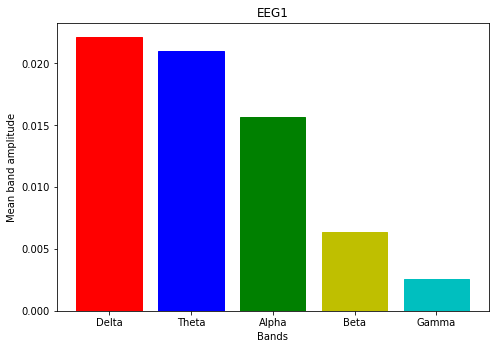

In [32]:
plot(features(train_eeg1), 'EEG1')

## Training

In [44]:
x_train = concatenate_signals(train_eeg1, train_eeg2, train_emg)
x_train.shape
# on-hot-encode y
enc = OneHotEncoder().fit(np.array(y_train).reshape(-1, 1))
y_train_oh = enc.transform(np.array(y_train).reshape(-1, 1))

In [45]:
look_back = 6
subject_size = 21600

In [46]:
# leave-one-out
x_trn1, y_trn1 = create_dataset(x_train[0:subject_size, :], y_train_oh[0:subject_size,:], look_back)
x_trn2, y_trn2 = create_dataset(x_train[subject_size+1:2*subject_size, :], y_train_oh[subject_size+1:2*subject_size,:], look_back)
x_val,  y_val  = create_dataset(x_train[2*subject_size+1:3*subject_size,:], y_train_oh[2*subject_size+1:3*subject_size,:], look_back)

In [47]:
x_trn = np.append(x_trn1, x_trn2, axis=0)
y_trn = np.append(y_trn1, y_trn2, axis=0)

In [48]:
# LSTM definition
model_lstm = Sequential()
model_lstm.add(LSTM(25, return_sequences=True,input_shape=(x_trn.shape[1], x_trn.shape[2])))
model_lstm.add(LSTM(units=30))
model_lstm.add(Dense(3, activation='softmax')) 
model_lstm.compile(loss=weighted_categorical_crossentropy(np.array([1/3.4114, 1/2.7133, 1/0.3553])), optimizer='adam')
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 12, 25)            3700      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                6720      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 93        
Total params: 10,513
Trainable params: 10,513
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Fit
history = model_lstm.fit(x_trn, y_trn, epochs=15, batch_size=64, validation_data=(x_val, y_val),  shuffle=False)

Epoch 1/15
675/675 [==============================] - 10s 10ms/step - loss: 5.1734e-05 - val_loss: 4.5814e-05
Epoch 2/15
675/675 [==============================] - 6s 9ms/step - loss: 5.1701e-05 - val_loss: 4.1250e-05
Epoch 3/15
675/675 [==============================] - 7s 10ms/step - loss: 4.2922e-05 - val_loss: 4.8145e-05
Epoch 4/15
675/675 [==============================] - 7s 10ms/step - loss: 3.8715e-05 - val_loss: 4.5113e-05
Epoch 5/15
675/675 [==============================] - 7s 10ms/step - loss: 3.3355e-05 - val_loss: 4.8040e-05
Epoch 6/15
675/675 [==============================] - 8s 12ms/step - loss: 2.7820e-05 - val_loss: 5.3104e-05
Epoch 7/15
675/675 [==============================] - 7s 10ms/step - loss: 2.5091e-05 - val_loss: 5.5449e-05
Epoch 8/15
675/675 [==============================] - 7s 10ms/step - loss: 2.3365e-05 - val_loss: 5.5826e-05
Epoch 9/15
675/675 [==============================] - 7s 10ms/step - loss: 2.1985e-05 - val_loss: 5.3849e-05
Epoch 10/15
675/675

In [50]:
# Evaluate
pred_val = model_lstm.predict(x_val)
pred_y_val = np.argmax(pred_val, axis=1) + 1
true_y_val = np.argmax(y_val, axis=1) + 1
print("Balanced accuracy score: ", balanced_accuracy_score(true_y_val, pred_y_val))
print("Confusion matrix\n", confusion_matrix(true_y_val, pred_y_val))

Balanced accuracy score:  0.7561438126071556
Confusion matrix
 [[8231   17 2771]
 [3920 5137  769]
 [   1    0  741]]


## Prediction

In [51]:
x_test1 = pd.read_csv("test_eeg1.csv", index_col='Id')
x_test2 = pd.read_csv("test_eeg2.csv", index_col='Id')
x_test3 = pd.read_csv("test_emg.csv", index_col='Id')

In [23]:
x_test = concatenate_signals(x_test1, x_test2, x_test3)

In [53]:
x_tst, _ = create_dataset(x_test)

In [54]:
# Predict
pred_tst = model_lstm.predict(x_tst)
pred_y_tst = np.argmax(pred_tst, axis=1) + 1

In [55]:
# lookback
solution = np.empty(x_test.shape[0])
solution[range(look_back,x_test.shape[0] - look_back)] = pred_y_tst
# for lookback impute first value and last values
solution[range(look_back)] = pred_y_tst[0]
solution[range(x_test.shape[0] - look_back,x_test.shape[0])] = pred_y_tst[-1]

ids = np.arange(0, len(solution))
output = pd.DataFrame({'Id': ids,
                           'y': solution})
output.to_csv("output.csv", index=False)